In [2]:
import rasterio
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [3]:
#train sample locations
train_points_path = 'data/vector/train_points.geojson'

#inverse distance to bird grid points
inv_dist_path = 'data/raster/wt_layers/distexp_1.tif'

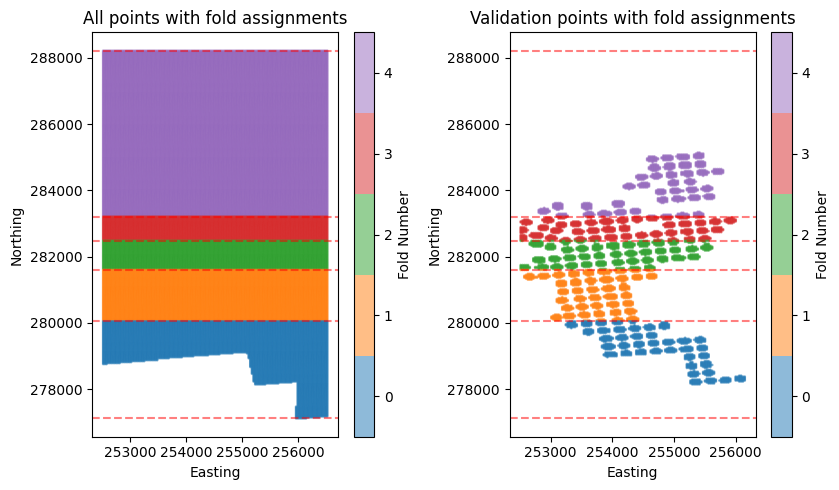

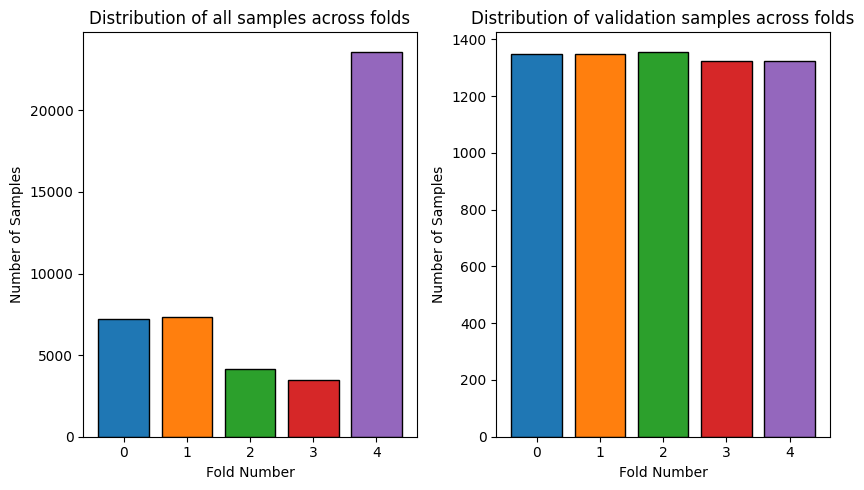

In [11]:
validation_thresh = 1/100 #points within 100m of bird grid points retained for validation
train_points = gpd.read_file(train_points_path)
with rasterio.open(inv_dist_path) as src:
    dist_to_bird_grid = [x[0] for x in src.sample(list(zip(train_points.geometry.x, train_points.geometry.y)))]
    train_points['valid'] = np.array(dist_to_bird_grid) > validation_thresh

# Get y-coordinates of all points and create bands based on percentiles
all_y = train_points.geometry.y
valid_y = train_points[train_points['valid']].geometry.y

# Create bands with southernmost band extending to min y of all points
# Using percentiles 100, 80, 60, 40, 20, 0 to create 5 bands
y_bands = np.concatenate([
    np.percentile(valid_y, [100, 80, 60, 40, 20, 0])
])[::-1]  # Reverse to go north to south

# Replace the boundaries with min and max of all points
y_bands[0] = train_points.geometry.y.min()
y_bands[-1] = train_points.geometry.y.max()

# Assign folds based on which band each point falls into
train_points['fold'] = pd.cut(train_points.geometry.y, bins=y_bands, labels=False, include_lowest=True)

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.5,5))  # Reduced width from 10 to 9

# Create a custom colormap with 5 distinct colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # 5 distinct colors
custom_cmap = matplotlib.colors.ListedColormap(colors)

# Plot all points with y_bands on first subplot
scatter1 = ax1.scatter(train_points.geometry.x, train_points.geometry.y,
                      c=train_points['fold'], cmap=custom_cmap, 
                      s=1, alpha=0.5, vmin=-0.5, vmax=4.5)
for y_val in y_bands:
    ax1.axhline(y=y_val, color='red', linestyle='--', alpha=0.5)
cbar1 = fig.colorbar(scatter1, ax=ax1, label='Fold Number', ticks=[0,1,2,3,4])
cbar1.set_ticklabels(['0','1','2','3','4'])
ax1.set_title('All points with fold assignments')
ax1.set_xlabel('Easting')
ax1.set_ylabel('Northing')

# Plot valid points with y_bands on second subplot
valid_points = train_points[train_points['valid']]
scatter2 = ax2.scatter(valid_points.geometry.x, valid_points.geometry.y,
                      c=valid_points['fold'], cmap=custom_cmap,
                      s=1, alpha=0.5, vmin=-0.5, vmax=4.5)
for y_val in y_bands:
    ax2.axhline(y=y_val, color='red', linestyle='--', alpha=0.5)
cbar2 = fig.colorbar(scatter2, ax=ax2, label='Fold Number', ticks=[0,1,2,3,4])
cbar2.set_ticklabels(['0','1','2','3','4'])
ax2.set_title('Validation points with fold assignments')
ax2.set_xlabel('Easting')
ax2.set_ylabel('Northing')

plt.tight_layout()
plt.show()

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.5,5))  # Reduced width from 10 to 9

# Plot distribution of all samples
fold_counts = train_points['fold'].value_counts().sort_index()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Same colors as map
ax1.bar(fold_counts.index, fold_counts.values, color=colors, edgecolor='black')
ax1.set_title('Distribution of all samples across folds')
ax1.set_xlabel('Fold Number')
ax1.set_ylabel('Number of Samples')

# Plot distribution of validation samples
valid_fold_counts = train_points[train_points['valid']]['fold'].value_counts().sort_index()
ax2.bar(valid_fold_counts.index, valid_fold_counts.values, color=colors, edgecolor='black')
ax2.set_title('Distribution of validation samples across folds')
ax2.set_xlabel('Fold Number')
ax2.set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()


In [12]:
train_points.to_file('data/vector/train_points_with_folds.geojson', driver='GeoJSON')